<font color='darkblue'>

# Data Analysis Interview Challenge (III)
    
## Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

    
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

    
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).
    
<font/>

## 1. Question #1

__Import data for manipulation__

In [1]:
import json
import pandas as pd

# Creates path for file
data_path2 = './data/ultimate_data_challenge.json'

# Opens jason file in read mode and load it in json_data variable
with open(data_path2, 'r') as json_file:
    json_data = json.load(json_file)

In [2]:
# Checks data type of the variable
type(json_data)

list

In [3]:
# Prints the first element of the list
json_data[0]

{'city': "King's Landing",
 'trips_in_first_30_days': 4,
 'signup_date': '2014-01-25',
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'surge_pct': 15.4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2,
 'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0}

We can see that the content of the json file has a structure of 'records'. We can convert this to a pandas df.

In [4]:
# Converts json file in a DataFrame
df = pd.read_json(data_path2, orient='record')

In [5]:
# Inspects the first five rows
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


The first step is to inspect the number of null entries and data types:

In [6]:
# Checks general info of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Then, I will inspect the main descriptive statistics:

In [7]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


We can see there are some missing values in columns 'avg_rating_of_driver', 'avg_rating_by_driver'and 'phone'.

Also, there is at least one outlier in 'trips_in_first_30_days' variable, and other in 'avg_dist', that seem input errors or very rare situations.

__Data cleaning__

For columns 'avg_rating_of_driver' and 'avg_rating_by_driver', I will assume that the lack of rating is because the driver and rider are new users and they do not have enough ratings to pull a reliable average. Therefore, I will fill the missing values with the mean of the existing values in the column.

For the column 'phone', I will remove the rows containing missing values. They seem input errors and they are difficult to infer, and the missing values represent less that 1% of the data. 

In [8]:
# Checks values in 'phone'
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [9]:
import numpy as np

# Selects empty values in 'phone'
df['phone'] = df['phone'].astype('str')
df['phone'] = df['phone'].apply(lambda x: x.strip())

# Removes rows with empty values in 'phone'
df = df[df['phone'] != 'nan']

In [10]:
# Replace missing values with mean value of the rest of entries
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

__Data types conversion__

I will assing the correct data types to each variable

In [11]:
# Convert date columns to datetime data type
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Convert boolean to 0/1 interger values
df = df.astype({"city": 'category', "phone": 'category', "ultimate_black_user": 'category'})

__Select target/response variable__

From the documentation, I do not know when is 'today' to check whether the user has made a trip in the last 30 days, so I will assume that 'today' is the most recent date in 'last_trip_date'. I will create a new column with the target variable.

In [12]:
from datetime import timedelta

# Selects 'today' date as the last date in 'last trip date'
today =  df['last_trip_date'].max()
# Creates a cutoff date to 
cutoff_date = today - timedelta(30)

print('Users are considered "retained" if they made at least one trip between {} and {}'.format(cutoff_date, today))

Users are considered "retained" if they made at least one trip between 2014-06-01 00:00:00 and 2014-07-01 00:00:00


In [13]:
# Creates a new column as the response variable
df['retained'] = (df['last_trip_date'] > cutoff_date)

In [14]:
# Calculates the percentage of retained users over total
df['retained'].value_counts() / df.shape[0]

False    0.633497
True     0.366503
Name: retained, dtype: float64

__Ultimate only retained 1/3 of the users that signed up during Jan 2014__

---

__Exploratory data analysis (EDA)__

The next cell presents the distributions of the numeric variables

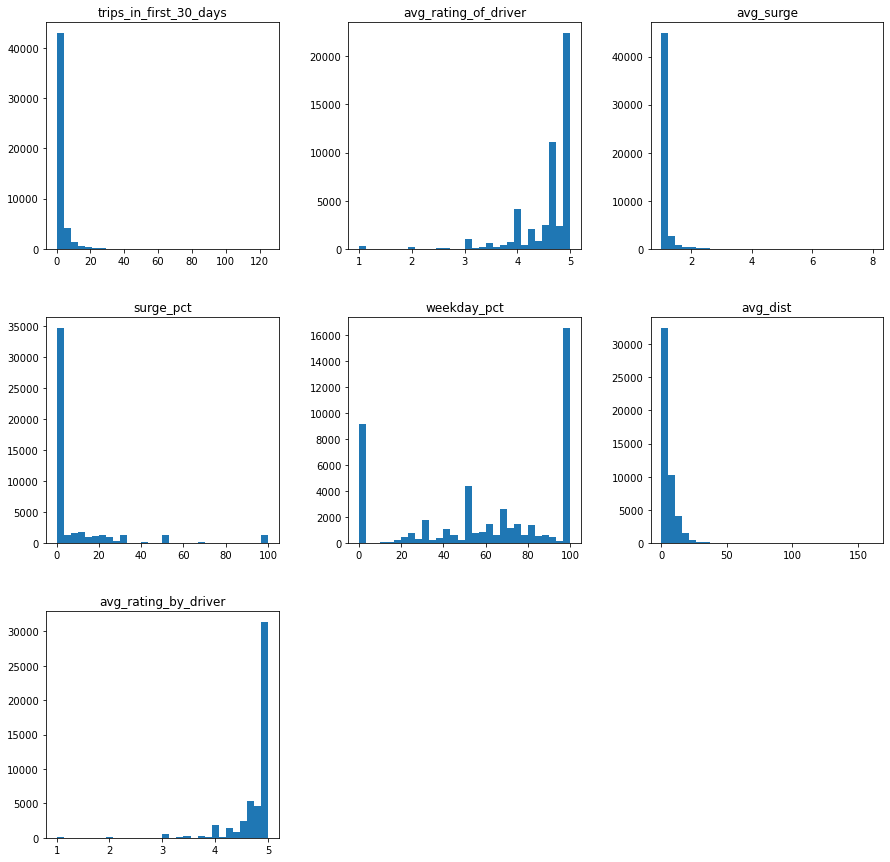

In [15]:
import matplotlib.pyplot as plt

df.select_dtypes(include=['int64','float64']).hist(bins=30, figsize=(15,15), grid=False)
plt.show()

We can see that none distribution is normal, most of the features have a exponential-like distributions. 

The cell below presents a correlation heatmap for diferent boolean and numerical features.

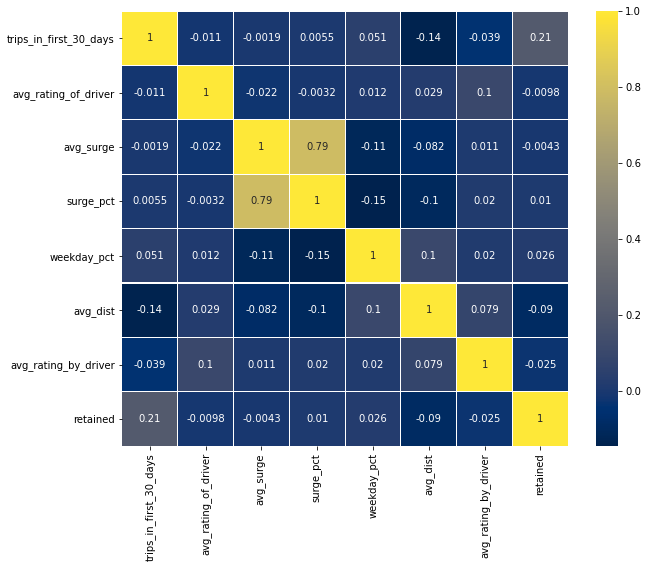

In [16]:
import seaborn as sns

df_corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(df_corr, cmap='cividis', cbar=True, annot=True, linewidths=0.1)
plt.show()

We can see almost any variable is correlated to each other except avg_surge and surge_pct. There is a weak relationship between user retention and trips made during the 30 days following the sign-ups; I will inspect this association further in the following cell: 

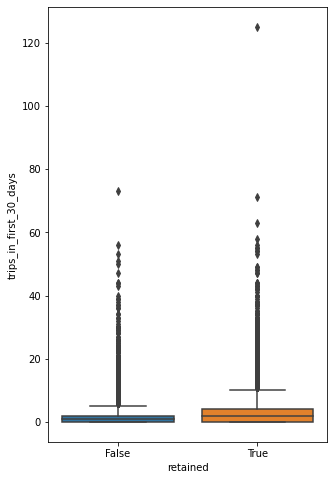

In [17]:
# Creates a boxplot 
plt.figure(figsize=(5,8))
sns.boxplot(x='retained', y='trips_in_first_30_days', data=df)
plt.show()

We can see that on average retained customers made more trips during the 30 days following the sign-up. 

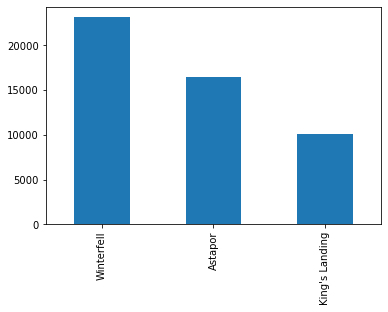

In [18]:
# Creates plot to show distribution of sign up origin cities
df['city'].value_counts().plot(kind='bar')
plt.show()

__Dealing with outliers__

We can see that in variables 'trips_in_first_30_days', 'avg_dist', and 'avg_surge' there are some extreme values that due to the nature of the data they are most likely input errors, i.e. an average rate surge of x8 when the 3rd quartile value is 1.05 is odd.

I will remove those outliers by simple cutting off values above a reasonable threshold.

In [19]:
# Removes values above a reasonable threshold
cond = (df['trips_in_first_30_days'] < 40) & (df['avg_dist'] < 50) & (df['avg_surge'] < 3)
df = df[cond]

# Computes the number of observations removed
print('{}% of the observations have been removed'.format(str(round(100-(cond.sum()*100/df.shape[0]), 1))))

0.0% of the observations have been removed


---

## 2. Question #2

__Building a predictive model for users retention__

The objective of this exercise is to help Ultimate to predict the users retention. Therefore, the model should be robust enough to make accurate predictions based on new data, that mean the mmodel should not be over or underfitted. The response variable will be the newly created 'retained' which accounts for active users in the 6th month after the sign-up (June).

I will choose Area Under Curve indicator (AUC) to measure the performance of the model, since we are dealing with inbalanced class labels. It is an performance indicator that measures the 

I will take the following steps to create the model:

1. Create a hold-out set to test the model at the very end of the process to make sure the model generalizes well and do not learn the data (overfitting).


2. Preprocess the dataset to make it readable to the model. I will perform this step independently for the train and hold-out set to avoid data leakage:
    - On hot encoding categorical variables. 
    - Standarize and scale the distributions.


3. Model selection; in this case it will be a supervised binary classification algorithm. 


4. Tune the hyperparameters of the model with cross validation to avoid model overfitting.


5. Evaluate the model and present results

__1. Create hold-out set__

The classes in the response variable are inbalanced, meaning that the proportion is not distributed evenly 50/50. The hold-out set should maintain the same proportion of class labels than in the original dataset.

In [20]:
from sklearn.model_selection import train_test_split

# Selects response and explanatory variables
X = df.drop(['retained', 'signup_date', 'last_trip_date'], axis=1)
y = df[['retained']]

# Creates train and hold-out (test) set in a stratified fashion so we get the same proportion of target labels in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, stratify=y)

__2. Preprocessing__

In this section, I will prepare the dataset to be processed by the classifier. Firstly, I will convert the categorical variables into numerical and then standarize the rest features to the same mean and std to equalize their weights. 

The transformers will be fitted with the train data and apply the transformation in the hold-out set. This will prevent data leakage between our dataset and unseen data.

In [21]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def preprocess(X_train, X_test):
    '''
    Performs a data transformation in both the training and unseen data.
    '''
    # Select categories for onhot encoding categorical features
    categories = [['Astapor', "King's Landing", 'Winterfell'],
                  ['Android', 'iPhone']]

    # Initialize transformers
    enc = OneHotEncoder(categories=categories, sparse=False, drop='first')
    mms = MinMaxScaler()

    # Fit and transform training data
    Xt1_train = enc.fit_transform(X_train[['city', 'phone']])
    Xt2_train = mms.fit_transform(X_train.drop(['city', 'phone'], axis=1))
    Xt_train = np.concatenate((Xt2_train, Xt1_train), axis=1)

    # Transform holdout test with transformers trained with train set
    Xt1_test = enc.transform(X_test[['city', 'phone']])
    Xt2_test = mms.transform(X_test.drop(['city', 'phone'], axis=1))
    Xt_test = np.concatenate((Xt2_test, Xt1_test), axis=1)
    
    return Xt_train, Xt_test

In [22]:
# Perform transformation
Xt_train, Xt_test = preprocess(X_train, X_test)

In [23]:
# Checks arrays sizes
Xt_train.shape, Xt_test.shape

((39504, 11), (9877, 11))

__3. Model selection__

I will try one of the most popular algorithms for classification: Logistic Regression. This algorithm will calculate coefficients for our features based on a sigmoid function and assign probabilities to each class.

Other alternatives could be K-Nearest Neighbors (KNN) and Support Vector Machines, which are based on distances among data points. The differenciates between classes by creating an hyperplane in the dimensional space.

In [24]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(class_weight='balanced')

__4. Hyperparameter optimization__

I will use exhaustive grid search to find the best parameters for our model. The metric used will be F1 score, which is a weighted average of the precision and recall and it is a good metric when dealing with class inbalances.

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': np.arange(0, 1, 0.1)}
scoring = 'f1'

lg_cv = GridSearchCV(lg, param_grid=parameters, scoring=scoring, n_jobs=-1)
lg_cv.fit(Xt_train, np.ravel(y_train))

print('Best parameters for the logistic regression estimator are:/n{}'.format(lg_cv.best_params_))
print('f1 score for the best logistic regression estimator is: {}'.format(round(lg_cv.best_score_, 3)))

Best parameters for the logistic regression estimator are:/n{'C': 0.7000000000000001, 'penalty': 'l2'}
f1 score for the best logistic regression estimator is: 0.626


__5. Model evaluation__

Finally, I will create a model and find out the f1 score for the hold-out set predictions.  

In [26]:
from sklearn.metrics import f1_score

logreg = LogisticRegression(C=0.7, penalty='l2', class_weight='balanced')

logreg.fit(Xt_train, np.ravel(y_train))

y_pred = logreg.predict(Xt_test)

print('f1 score for the hold-out set is: {}'.format(round(f1_score(y_test, y_pred), 3)))

f1 score for the hold-out set is: 0.636


In [27]:
# Get column names of the preprocessed dataset
columns = X_train.drop(['city', 'phone'], axis=1).columns.to_list() + ["from_King's Landing", 'from_Winterfell', 'has_iPhone']

# Get the coefficients of the features calculated by the log reg model and print them
coefs = pd.DataFrame(logreg.coef_, columns=columns)
coefs.T

,0
trips_in_first_30_days,4.926892
avg_rating_of_driver,-0.250995
avg_surge,0.137808
surge_pct,0.212480
ultimate_black_user,0.889007
weekday_pct,0.116446
avg_dist,-1.898190
avg_rating_by_driver,-0.721362
from_King's Landing,1.764842
from_Winterfell,0.540030


Our model presents a f1 score of 0.626 for the train model and 0.636 for the hold-out set, meaning that the model generalizes quite well and is not overfitted. However, ~0.6 is not a great score considering that a random classifier will score 0.5. We can conclude that our model is robust but its prediction power is not great. 

Other approaches to this problem could be try different transformations to the data in the preprocessing step and/or try different algorithms.

---

## 3. Question #3

The model can be used to predict whether a new user is likely to continue using the service after six months, and target marketing campaings to those users.  

Also, the coefficients generated by the model show that "trips_in_first_30_days" has almost three times more weight in the prediction than the second most important feature (avg_dist), as we also saw in the EDA section. Feature weights are very useful to understand what is driving retention or what attribute is highly correlated the user retention rate. 

The management could encourage usage in the first 30 days following the sign-up to increase the retention or could make further studies to understand why users that ride lower distances on average are more likely to quit the service. 